Mounted at /content/drive


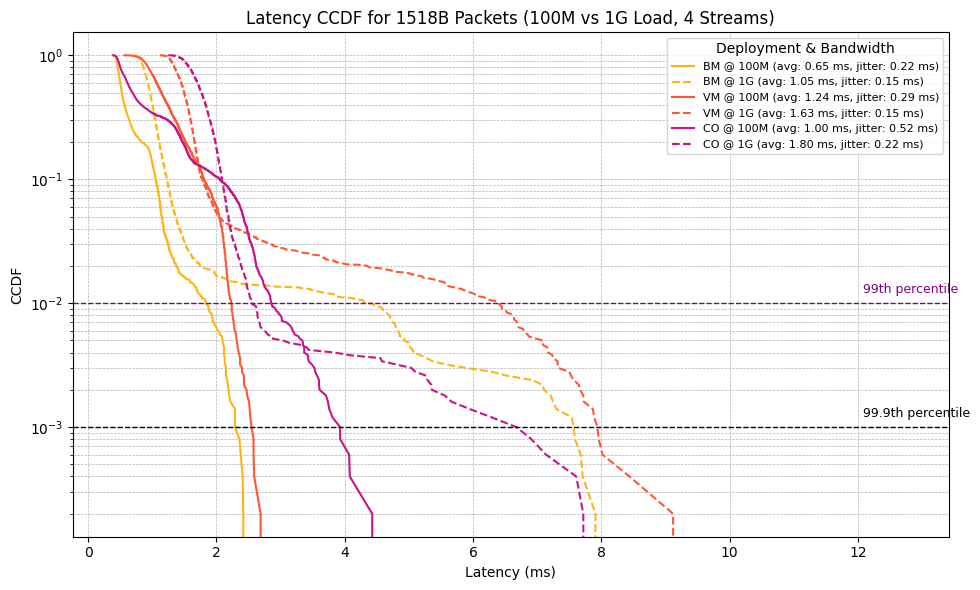

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# ============ CONFIGURATION ============
deployments = ["BM", "VM", "CO"]
packet_size = "1518"  # Focus only on 1518B
linestyles = {"100M": "-", "1G": "--"}  # Line styles for different bandwidths
colors = {"BM": "#FDB515", "VM": "#FF5733", "CO": "#C71585"}  # Distinct colors
stream_folder = "4streams"  # <-- UPDATED
# =======================================

# Extract latency values in ms
def extract_latencies(filepath):
    latencies = []
    with open(filepath, "r") as f:
        for line in f:
            match = re.search(r'time=(\d+\.\d+)', line)
            if match:
                latencies.append(float(match.group(1)))
    return np.array(latencies)

# Calculate average jitter
def calculate_jitter(latencies):
    return np.mean(np.abs(np.diff(latencies)))

# Plotting
plt.figure(figsize=(10, 6))

for dep in deployments:
    for bw in ["100M", "1G"]:
        path = f"/content/drive/MyDrive/Test files/{dep}/latency/{stream_folder}/{bw}"
        file_name = f"ping_{packet_size}_{bw}.log"
        file_path = os.path.join(path, file_name)

        if not os.path.exists(file_path):
            print(f"❌ Missing: {file_path}")
            continue

        latencies = extract_latencies(file_path)
        if len(latencies) == 0:
            print(f"⚠️ No latencies found in {file_path}")
            continue

        sorted_lat = np.sort(latencies)
        ccdf = 1.0 - np.arange(1, len(sorted_lat) + 1) / len(sorted_lat)

        avg_latency = np.mean(latencies)
        avg_jitter = calculate_jitter(latencies)

        label = f"{dep} @ {bw} (avg: {avg_latency:.2f} ms, jitter: {avg_jitter:.2f} ms)"
        plt.plot(sorted_lat, ccdf, label=label, linestyle=linestyles[bw], color=colors[dep])

# Reference lines for percentiles
plt.axhline(1e-2, color="purple", linestyle="--", linewidth=1)
plt.text(plt.xlim()[1] * 0.9, 1e-2 * 1.2, "99th percentile", color="purple", fontsize=9)
plt.axhline(1e-3, color="black", linestyle="--", linewidth=1)
plt.text(plt.xlim()[1] * 0.9, 1e-3 * 1.2, "99.9th percentile", color="black", fontsize=9)

# Final plot formatting
plt.yscale("log")
plt.xlabel("Latency (ms)")
plt.ylabel("CCDF")
plt.title("Latency CCDF for 1518B Packets (100M vs 1G Load, 4 Streams)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Deployment & Bandwidth", fontsize=8, loc="upper right")
plt.tight_layout()
plt.show()
